In [45]:
pip install openpyxl

Note: you may need to restart the kernel to use updated packages.


In [17]:
from os.path import dirname, join, pardir
from cobra.io import read_sbml_model
from dfba import DfbaModel, ExchangeFlux, KineticVariable
import pygad
import numpy
import cobra
from cobra import Model, Reaction, Metabolite
from dfba.plot.plotly import *
import plotly.io as pio
import matplotlib.pyplot as plt
import pandas as pd

In [18]:
yali = cobra.io.read_sbml_model('yalinewpathways.xml')

--- Logging error ---
Traceback (most recent call last):
  File "/home/jeremy/anaconda3/envs/dfba/lib/python3.7/site-packages/cobra/core/model.py", line 207, in tolerance
    solver_tolerances.optimality = value
  File "/home/jeremy/anaconda3/envs/dfba/lib/python3.7/site-packages/optlang/util.py", line 311, in __setattr__
    raise AttributeError(key + " is not an available tolerance parameter with this solver")
AttributeError: optimality is not an available tolerance parameter with this solver

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/jeremy/anaconda3/envs/dfba/lib/python3.7/logging/__init__.py", line 1028, in emit
    stream.write(msg + self.terminator)
  File "/home/jeremy/anaconda3/envs/dfba/lib/python3.7/tempfile.py", line 481, in func_wrapper
    return func(*args, **kwargs)
ValueError: I/O operation on closed file.
Call stack:
  File "/home/jeremy/anaconda3/envs/dfba/lib/python3.7/runpy.py", line 193, i

In [19]:
yali.solver = "glpk"
dfba_model = DfbaModel(yali)

In [20]:
# instances of KineticVariable (default initial conditions are 0.0, but can be
# set here if wanted e.g. Oxygen)
X = KineticVariable("Biomass")
Gluc = KineticVariable("Glucose")
Xyl = KineticVariable("Xylose")
Oxy = KineticVariable("Oxygen", initial_condition=0.24)
Eth = KineticVariable("Ethanol")

In [21]:
# instances of ExchangeFlux
mu = ExchangeFlux("xBIOMASS")
v_G = ExchangeFlux("y001714")
v_Z = ExchangeFlux("y001718")
v_O = ExchangeFlux("y001992")
v_E = ExchangeFlux("y001761")
# add exchange fluxes to dfba_model
dfba_model.add_exchange_fluxes([mu, v_G, v_Z, v_O, v_E])

In [22]:
# add kinetic variables to dfba_model
dfba_model.add_kinetic_variables([X, Gluc, Xyl, Oxy, Eth])

In [23]:
# add rhs expressions for kinetic variables in dfba_model
dfba_model.add_rhs_expression("Biomass", mu * X)
dfba_model.add_rhs_expression("Glucose", v_G * 180.1559 * X / 1000.0)
dfba_model.add_rhs_expression("Xylose", v_Z * 150.13 * X / 1000.0)
dfba_model.add_rhs_expression("Oxygen", v_O * 16.0 * X / 1000.0)
dfba_model.add_rhs_expression("Ethanol", v_E * 46.06844 * X / 1000.0)

In [24]:
# add lower/upper bound expressions for exchange fluxes in dfba_model together
# with expression that must be non-negative for correct evaluation of bounds
dfba_model.add_exchange_flux_lb(
    "y001714", 8 * (Gluc / (0.0027 + Gluc)) * (1 / (1 + Eth / 20.0)), Gluc
) #10.5
dfba_model.add_exchange_flux_lb("y001992", 15.0 * (Oxy / (0.024 + Oxy)), Oxy)
dfba_model.add_exchange_flux_lb(
    "y001718",
    6.0 * (Xyl / (0.0165 + Xyl)) * (1 / (1 + Eth / 20.0)) * (1 / (1 + Gluc / 0.005)),
    Xyl,
)

In [32]:
dfba_model.add_initial_conditions(
    {
        "Biomass": 0.1,
        "Glucose": 15.5,
        "Xylose": 8.0,
        "Oxygen": 5.0,
        "Ethanol": 4.0,
    }
)
concentrations, trajectories = dfba_model.simulate(0.0, 15, 0.1, ["y001714", "y001718", "y001761"])

cc1plus: warning: command line option '-Wstrict-prototypes' is valid for C/ObjC but not for C++




Final Run Statistics: 

Number of steps                    = 50
Number of residual evaluations     = 264
Number of Jacobian evaluations     = 32
Number of nonlinear iterations     = 130
Number of error test failures      = 21
Number of nonlinear conv. failures = 2
Number of root fn. evaluations     = 125


Final Run Statistics: 

Number of steps                    = 0
Number of residual evaluations     = 0
Number of Jacobian evaluations     = 98
Number of nonlinear iterations     = 0
Number of error test failures      = 0
Number of nonlinear conv. failures = 0
Number of root fn. evaluations     = 0

Total simulation time was 13.888 seconds



In [33]:
# in plotly version 4, default version is different than in 3
pio.templates.default = "plotly_white"

In [34]:
fig = plot_concentrations(concentrations)
fig.show()

In [35]:
concentrations

,time,Biomass,Ethanol,Glucose,Oxygen,Xylose
0,0.0,0.100000,4.0,1.550000e+01,5.000000,8.000000e+00
1,0.1,0.107302,4.0,1.548756e+01,4.997959,7.999997e+00
2,0.2,0.115145,4.0,1.547419e+01,4.995767,7.999995e+00
3,0.3,0.123595,4.0,1.545979e+01,4.993405,7.999992e+00
4,0.4,0.132658,4.0,1.544434e+01,4.990872,7.999989e+00
...,...,...,...,...,...,...
146,14.6,13.815252,4.0,-2.435981e-08,1.101517,-5.048948e-09
147,14.7,13.815252,4.0,-2.435981e-08,1.101517,-5.048948e-09
148,14.8,13.815252,4.0,-2.435981e-08,1.101517,-5.048948e-09
149,14.9,13.815252,4.0,-2.435981e-08,1.101517,-5.048948e-09


In [36]:
trajectories

,time,y001714,y001718,y001761
0,0.0,0.000000,0.000000,0.0
1,0.1,-6.665505,-0.001610,0.0
2,0.2,-6.665504,-0.001612,0.0
3,0.3,-6.665503,-0.001613,0.0
4,0.4,-6.665501,-0.001615,0.0
...,...,...,...,...
146,14.6,0.000000,0.000000,0.0
147,14.7,0.000000,0.000000,0.0
148,14.8,0.000000,0.000000,0.0
149,14.9,0.000000,0.000000,0.0


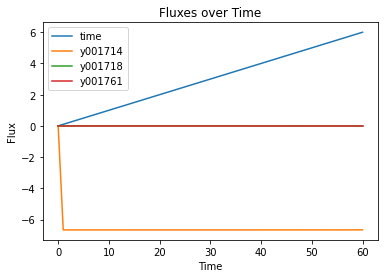

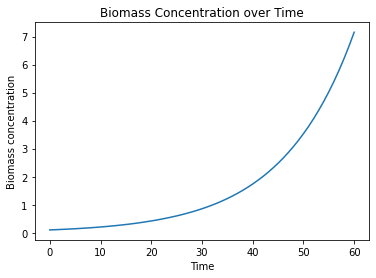

In [30]:

# To plot a trajectory
plt.figure()
plt.title("Fluxes over Time")
for flux_id, trajectory in trajectories.items():
    plt.plot(concentrations.index, trajectory, label=flux_id)
plt.xlabel('Time')
plt.ylabel('Flux')
plt.legend()
plt.show()

# To plot the biomass concentration over time
plt.figure()
plt.title("Biomass Concentration over Time")
plt.plot(concentrations.index, concentrations["Biomass"])
plt.xlabel('Time')
plt.ylabel('Biomass concentration')
plt.show()

In [31]:
# Export concentrations DataFrame to Excel
concentrations.to_excel("concentrationresultados1.1.xlsx")

# Export trajectories DataFrame to Excel
trajectories.to_excel("trajectoriesresultados1.1.xlsx")

In [43]:
yali.objective='xBIOMASS'#'y001882' #yali.reactions.xBIOMASS
solution = yali.optimize()
solution.fluxes

xAMINOACID      0.105692
xBIOMASS        0.105692
xLIPID          0.000106
xMAINTENANCE    0.000000
xPOOL_AC_EM     0.011949
                  ...   
y300092         0.000000
y300093         0.000000
y300094         0.000000
y300095         0.000000
y300096         0.000000
Name: fluxes, Length: 1938, dtype: float64

In [50]:
# Convert the solution's fluxes to a pandas DataFrame
fluxes = pd.DataFrame.from_dict(solution.fluxes)

# Write the DataFrame to an Excel file
fluxes.to_excel('solutions1.1_fba_fluxes.xlsx')

In [53]:
yali.reactions.y000446

Reaction identifier,y000446
Name,formate-tetrahydrofolate ligase
Memory address,0x7f914a56a9d0
Stoichiometry,s_0434 + s_0722 + s_1487 <=> s_0120 + s_0394 + s_1322 ATP + formate + THF <=> 10-formyl-THF + ADP + phosphate
GPR,YALI0E01056g or YALI0F30745g
Lower bound,-1000.0
Upper bound,1000.0


In [54]:
yali.reactions.y000499


Reaction identifier,y000499
Name,glycinamide ribotide transformylase
Memory address,0x7f914a53aad0
Stoichiometry,s_0120 + s_0325 --> s_0301 + s_0794 + s_1487 10-formyl-THF + 5-phospho-ribosyl-glycineamide --> 5'-phosphoribosyl-N-formylglycineamide + H+ + THF
GPR,YALI0D03069g
Lower bound,0.0
Upper bound,1000.0


In [55]:
yali.reactions.y000851


Reaction identifier,y000851
Name,phenylalanine transaminase
Memory address,0x7f914a292a10
Stoichiometry,s_0180 + s_1032 <=> s_0951 + s_0991 2-oxoglutarate + L-phenylalanine <=> keto-phenylpyruvate + L-glutamate
GPR,YALI0E20977g
Lower bound,-1000.0
Upper bound,1000.0


In [56]:
yali.reactions.y001063


Reaction identifier,y001063
Name,tyrosine transaminase
Memory address,0x7f914a171a50
Stoichiometry,s_0204 + s_0991 <=> s_0180 + s_1051 3-(4-hydroxyphenyl)pyruvate + L-glutamate <=> 2-oxoglutarate + L-tyrosine
GPR,YALI0E20977g
Lower bound,-1000.0
Upper bound,1000.0


In [57]:
yali.reactions.y001112


Reaction identifier,y001112
Name,"AKG transporter, mitochonrial"
Memory address,0x7f914a0d2a10
Stoichiometry,s_0180 + s_0524 <=> s_0182 + s_0522 2-oxoglutarate + citrate <=> 2-oxoglutarate + citrate
GPR,YALI0B10736g
Lower bound,-1000.0
Upper bound,1000.0


In [58]:
yali.reactions.y001126


Reaction identifier,y001126
Name,citrate transport
Memory address,0x7f914a0f3c50
Stoichiometry,s_0068 + s_0522 <=> s_0066 + s_0524 (S)-malate + citrate <=> (S)-malate + citrate
GPR,YALI0F26323g
Lower bound,-1000.0
Upper bound,1000.0


In [59]:
yali.reactions.y001824


Reaction identifier,y001824
Name,H+ diffusion
Memory address,0x7f9149ee5750
Stoichiometry,s_0796 --> s_0794 H+ --> H+
GPR,
Lower bound,0.0
Upper bound,1000.0


In [60]:
yali.reactions.y001832


Reaction identifier,y001832
Name,H+ exchange
Memory address,0x7f9149eed390
Stoichiometry,s_0796 <=> H+ <=>
GPR,
Lower bound,-1000.0
Upper bound,1000.0


In [61]:
yali.reactions.y002117


Reaction identifier,y002117
Name,phenylalanine transaminase
Memory address,0x7f9149dbfb10
Stoichiometry,s_1032 + s_1399 <=> s_0951 + s_0955 L-phenylalanine + pyruvate <=> keto-phenylpyruvate + L-alanine
GPR,YALI0C05258g
Lower bound,-1000.0
Upper bound,1000.0


In [62]:
yali.reactions.y002119


Reaction identifier,y002119
Name,tyrosine transaminase
Memory address,0x7f9149dbffd0
Stoichiometry,s_0204 + s_0955 <=> s_1051 + s_1399 3-(4-hydroxyphenyl)pyruvate + L-alanine <=> L-tyrosine + pyruvate
GPR,YALI0C05258g
Lower bound,-1000.0
Upper bound,1000.0


In [63]:
yali.reactions.y002132


Reaction identifier,y002132
Name,oxoglutarate/malate exchange
Memory address,0x7f9149dbf5d0
Stoichiometry,s_0066 + s_0182 --> s_0068 + s_0180 (S)-malate + 2-oxoglutarate --> (S)-malate + 2-oxoglutarate
GPR,YALI0D02629g
Lower bound,0.0
Upper bound,1000.0


In [64]:
yali.reactions.y200001

Reaction identifier,y200001
Name,glycinamide ribonucleotide transformylase
Memory address,0x7f9149b03d10
Stoichiometry,s_0325 + s_0434 + s_0722 --> s_0301 + s_0394 + s_1322 5-phospho-ribosyl-glycineamide + ATP + formate --> 5'-phosphoribosyl-N-formylglycineamide + ADP + phosphate
GPR,YALI0B23188g
Lower bound,0.0
Upper bound,1000.0
